In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

import torch
import torch.nn as nn

import torchvision.transforms as transforms
import torchvision.datasets as TVdatasets

import torchattacks
from torchattacks import PGD, FGSM

from tqdm.notebook import tqdm

### Load MNIST data

In [4]:
mnist_transform = transforms.Compose([transforms.ToTensor()])

mnist_train_data = TVdatasets.MNIST(root='../data', 
                                    train=True,
                                    transform=mnist_transform,
                                    download=True)

mnist_test_data = TVdatasets.MNIST(root='../data',
                                  train=False,
                                  transform=mnist_transform,
                                  download=True)

num_train_samples = len(mnist_train_data)
num_test_samples = len(mnist_test_data)

print("Number of train samples:", num_train_samples)
print("Number of test samples:", num_test_samples)

Number of train samples: 60000
Number of test samples: 10000


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device=='cuda' else {}

train_batch_size = 32
test_batch_size = 32

trainloader = torch.utils.data.DataLoader(dataset=mnist_train_data,
                                         batch_size=train_batch_size,
                                         shuffle=True,
                                         **kwargs)

testloader = torch.utils.data.DataLoader(dataset=mnist_test_data,
                                        batch_size=test_batch_size,
                                        shuffle=False,
                                        **kwargs)

### Model class

In [6]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer = nn.Sequential(
            nn.Conv2d(1,16,5), # 16*24*24
            nn.ReLU(),
            nn.Conv2d(16,32,5), # 32*20*20
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 32*10*10
            nn.Conv2d(32,64,5), # 64*6*6
            nn.ReLU(),
            nn.MaxPool2d(2,2) #64*3*3
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(64*3*3,100),
            nn.ReLU(),
            nn.Linear(100,10)
        )       
        
    def forward(self,x):
        out = self.layer(x)
        out = out.view(-1,64*3*3)
        out = self.fc_layer(out)

        return out

model = CNN().to(device)

In [7]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
pgd_attack = PGD(model, eps=0.3, alpha=0.1, steps=10)
fgsm_attack = FGSM(model, eps=0.3)

num_batches = len(mnist_train_data) // train_batch_size
num_epochs = 5
loss_lst = []

for epoch in range(num_epochs):
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(trainloader)):
        batch_imgs = batch_imgs.to(device)
        batch_labels = batch_labels.to(device)
        
        batch_adv_imgs = pgd_attack(batch_imgs, batch_labels)
        
        X_train = torch.cat((batch_adv_imgs, batch_imgs), 0)   
        Y_train_gt = torch.cat((batch_labels, batch_labels), 0)
        Y_train_pred = model(X_train)

        loss_val = loss(Y_train_pred, Y_train_gt)
        
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()
        
        if (itr + 1) % 100 == 0:
            print("Epoch [{}/{}], Iteration [{}/{}], Loss:{}".format(epoch+1, num_epochs, 
                                                                        itr+1, num_batches, 
                                                                        round(loss_val.item(),4)))
        
        loss_lst.append(loss_val.item())

  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [1/5], Iteration [100/1875], Loss:1.4107
Epoch [1/5], Iteration [200/1875], Loss:0.9505
Epoch [1/5], Iteration [300/1875], Loss:0.8245
Epoch [1/5], Iteration [400/1875], Loss:0.5658
Epoch [1/5], Iteration [500/1875], Loss:0.4219
Epoch [1/5], Iteration [600/1875], Loss:0.6064
Epoch [1/5], Iteration [700/1875], Loss:0.4207
Epoch [1/5], Iteration [800/1875], Loss:0.4709
Epoch [1/5], Iteration [900/1875], Loss:0.2974
Epoch [1/5], Iteration [1000/1875], Loss:0.4068
Epoch [1/5], Iteration [1100/1875], Loss:0.18
Epoch [1/5], Iteration [1200/1875], Loss:0.3809
Epoch [1/5], Iteration [1300/1875], Loss:0.2924
Epoch [1/5], Iteration [1400/1875], Loss:0.2829
Epoch [1/5], Iteration [1500/1875], Loss:0.417
Epoch [1/5], Iteration [1600/1875], Loss:0.2899
Epoch [1/5], Iteration [1700/1875], Loss:0.1099
Epoch [1/5], Iteration [1800/1875], Loss:0.0673


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [2/5], Iteration [100/1875], Loss:0.091
Epoch [2/5], Iteration [200/1875], Loss:0.2211
Epoch [2/5], Iteration [300/1875], Loss:0.23
Epoch [2/5], Iteration [400/1875], Loss:0.2431
Epoch [2/5], Iteration [500/1875], Loss:0.2398
Epoch [2/5], Iteration [600/1875], Loss:0.1205
Epoch [2/5], Iteration [700/1875], Loss:0.3048
Epoch [2/5], Iteration [800/1875], Loss:0.0759
Epoch [2/5], Iteration [900/1875], Loss:0.3526
Epoch [2/5], Iteration [1000/1875], Loss:0.0955
Epoch [2/5], Iteration [1100/1875], Loss:0.0907
Epoch [2/5], Iteration [1200/1875], Loss:0.2603
Epoch [2/5], Iteration [1300/1875], Loss:0.2311
Epoch [2/5], Iteration [1400/1875], Loss:0.0679
Epoch [2/5], Iteration [1500/1875], Loss:0.0438
Epoch [2/5], Iteration [1600/1875], Loss:0.1476
Epoch [2/5], Iteration [1700/1875], Loss:0.3182
Epoch [2/5], Iteration [1800/1875], Loss:0.0804


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [3/5], Iteration [100/1875], Loss:0.2579
Epoch [3/5], Iteration [200/1875], Loss:0.2091
Epoch [3/5], Iteration [300/1875], Loss:0.0166
Epoch [3/5], Iteration [400/1875], Loss:0.4589
Epoch [3/5], Iteration [500/1875], Loss:0.0391
Epoch [3/5], Iteration [600/1875], Loss:0.0643
Epoch [3/5], Iteration [700/1875], Loss:0.069
Epoch [3/5], Iteration [800/1875], Loss:0.3003
Epoch [3/5], Iteration [900/1875], Loss:0.0553
Epoch [3/5], Iteration [1000/1875], Loss:0.1624
Epoch [3/5], Iteration [1100/1875], Loss:0.0685
Epoch [3/5], Iteration [1200/1875], Loss:0.0349
Epoch [3/5], Iteration [1300/1875], Loss:0.1371
Epoch [3/5], Iteration [1400/1875], Loss:0.0236
Epoch [3/5], Iteration [1500/1875], Loss:0.0636
Epoch [3/5], Iteration [1600/1875], Loss:0.0294
Epoch [3/5], Iteration [1700/1875], Loss:0.0172
Epoch [3/5], Iteration [1800/1875], Loss:0.0139


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [4/5], Iteration [100/1875], Loss:0.0437
Epoch [4/5], Iteration [200/1875], Loss:0.1545
Epoch [4/5], Iteration [300/1875], Loss:0.0312
Epoch [4/5], Iteration [400/1875], Loss:0.1172
Epoch [4/5], Iteration [500/1875], Loss:0.2146
Epoch [4/5], Iteration [600/1875], Loss:0.0277
Epoch [4/5], Iteration [700/1875], Loss:0.1992
Epoch [4/5], Iteration [800/1875], Loss:0.3594
Epoch [4/5], Iteration [900/1875], Loss:0.0517
Epoch [4/5], Iteration [1000/1875], Loss:0.1248
Epoch [4/5], Iteration [1100/1875], Loss:0.0329
Epoch [4/5], Iteration [1200/1875], Loss:0.2082
Epoch [4/5], Iteration [1300/1875], Loss:0.0938
Epoch [4/5], Iteration [1400/1875], Loss:0.0158
Epoch [4/5], Iteration [1500/1875], Loss:0.0485
Epoch [4/5], Iteration [1600/1875], Loss:0.0258
Epoch [4/5], Iteration [1700/1875], Loss:0.0609
Epoch [4/5], Iteration [1800/1875], Loss:0.0809


  0%|          | 0/1875 [00:00<?, ?it/s]

Epoch [5/5], Iteration [100/1875], Loss:0.0777
Epoch [5/5], Iteration [200/1875], Loss:0.1029
Epoch [5/5], Iteration [300/1875], Loss:0.0887
Epoch [5/5], Iteration [400/1875], Loss:0.1561
Epoch [5/5], Iteration [500/1875], Loss:0.1052
Epoch [5/5], Iteration [600/1875], Loss:0.0127
Epoch [5/5], Iteration [700/1875], Loss:0.0622
Epoch [5/5], Iteration [800/1875], Loss:0.1989
Epoch [5/5], Iteration [900/1875], Loss:0.0815
Epoch [5/5], Iteration [1000/1875], Loss:0.0838
Epoch [5/5], Iteration [1100/1875], Loss:0.0477
Epoch [5/5], Iteration [1200/1875], Loss:0.0211
Epoch [5/5], Iteration [1300/1875], Loss:0.0907
Epoch [5/5], Iteration [1400/1875], Loss:0.0907
Epoch [5/5], Iteration [1500/1875], Loss:0.0165
Epoch [5/5], Iteration [1600/1875], Loss:0.0079
Epoch [5/5], Iteration [1700/1875], Loss:0.0594
Epoch [5/5], Iteration [1800/1875], Loss:0.0464


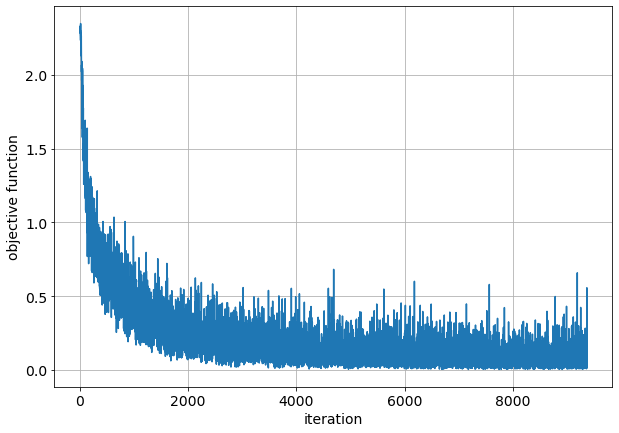

In [9]:
plt.figure(figsize=(10,7))
plt.plot(loss_lst)
plt.xlabel("iteration")
plt.ylabel("objective function")
plt.grid()
plt.show()

### Test accuracy (standard clean)

In [10]:
num_samples = 0
num_corr_pred = 0
model.eval()

with torch.no_grad():
    for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
        X_test = batch_imgs.to(device)
        Y_test_gt = batch_labels.to(device)

        _, Y_test_pred = torch.max(model(X_test), dim=1)
    #     print(Y_test_gt.shape, Y_test_pred.shape)

        num_samples += batch_imgs.shape[0]
        num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Standard clean accuracy: {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Standard clean accuracy: 99.11 %


### Test accuracy (PGD attack)

In [11]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)

    X_test = pgd_attack(batch_imgs, batch_labels)
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (PGD attack): 95.35 %


### Test accuracy (FGSM attack)

In [12]:
num_samples = 0
num_corr_pred = 0
model.eval()

# with torch.no_grad():
for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
#     print(batch_imgs.shape, batch_labels.shape)

    X_test = fgsm_attack(batch_imgs, batch_labels)
    Y_test_gt = batch_labels

    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += batch_imgs.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM attack): 96.91 %


### Test accuracy (FGSM + PGD - attack)

In [14]:
num_samples = 0
num_corr_pred = 0
model.eval()

for itr, (batch_imgs, batch_labels) in enumerate(tqdm(testloader)):
    batch_imgs = batch_imgs.to(device)
    batch_labels = batch_labels.to(device)
    
    X_adv_fgsm_imgs = fgsm_attack(batch_imgs, batch_labels)
    X_adv_pgd_imgs = pgd_attack(batch_imgs, batch_labels)
    
    X_test = torch.cat((X_adv_fgsm_imgs, X_adv_pgd_imgs), 0)
    Y_test_gt = torch.cat((batch_labels, batch_labels), 0)
    
    _, Y_test_pred = torch.max(model(X_test), dim=1)

    num_samples += Y_test_gt.shape[0]
    num_corr_pred += (Y_test_pred == Y_test_gt).sum()

test_accuracy = round(100.0 * float(num_corr_pred) / num_samples, 4)
print("Robust accuracy (FGSM + PGD attack): {} %".format(test_accuracy))

  0%|          | 0/313 [00:00<?, ?it/s]

Robust accuracy (FGSM + PGD attack): 96.235 %
